Import the PREFFECT package into Python (with necessary libraries).

In [1]:
import sys
import os
import numpy as np
import torch

# load PREFFECT classes into the Jupyter Notebook
sys.path.insert(0, '/data/lab_vm/release/')
from preffect import *

# it's good practice to limit threads used per runs
num_processors = 2
torch.set_num_threads(num_processors)
torch.set_num_interop_threads(num_processors)

Initializing the PREFFECT factory:

The `factory()` function configures a session and controls the workflow for the user.

Parameters can be set when initializing factory().

All parameters not implicitly set here will be read from `_config.py`.

In [ ]:
fac = factory(visualize=True,                                
            type='simple', # Choose your PREFFECT model type
            calT=1, # number of tissues (only 'full' type can be >1)
            model_likelihood = 'NB', # NB or ZINB (the latter for data with high dropout)
            epochs = 1000,  # Number of epochs during training
            mini_batch_size = 50 , # num. of samples per minibatch
            correct_vars = True, # Include additional variables within the model 
            vars_to_correct = [('batch', 'categorical')],
            X_recon_weight=100, # weights to expression reconstruction loss
            X_KL_weight=[0.1] # weights to expression KL divergence
)

Training your PREFFECT Model:

When completed, PREFFECT will display a plot of all losses computed during training.

Additional plots can be found in your output path (set parameter: "output_path").

Training Progress: 100%|██████████| 1000/1000 [04:56<00:00,  3.37it/s]


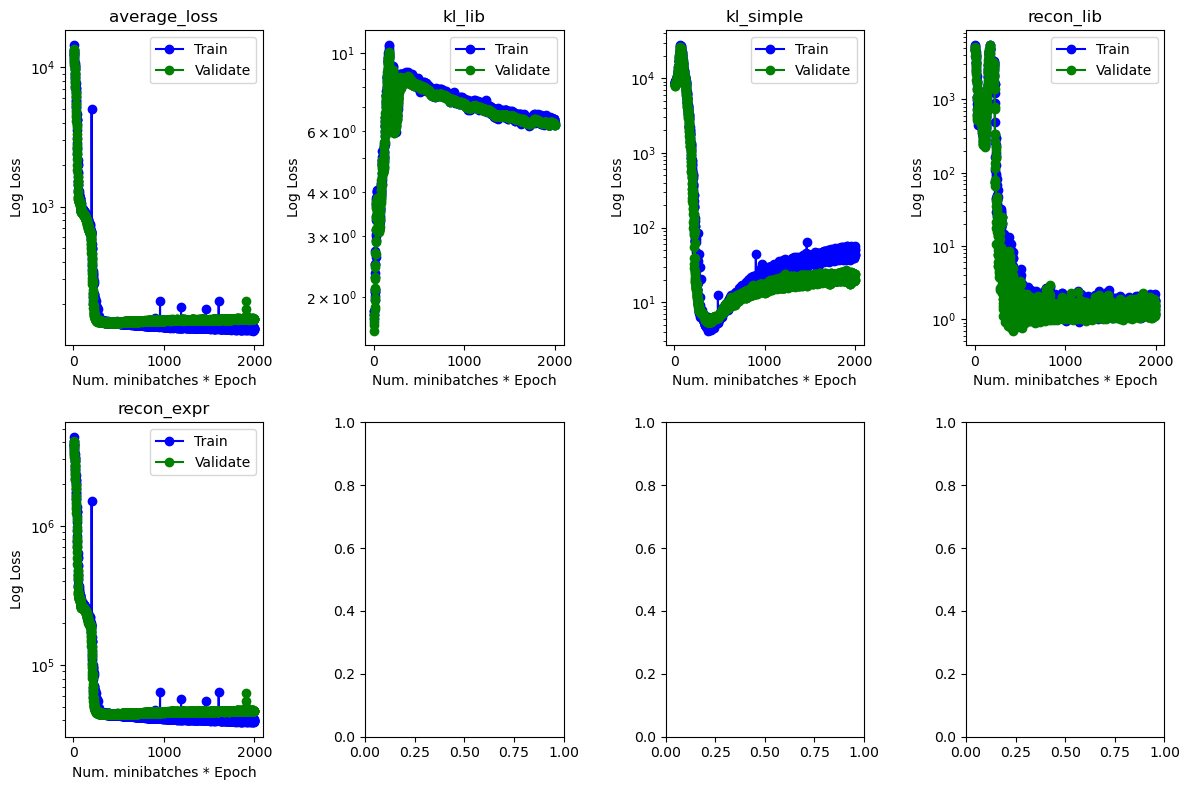

<Figure size 640x480 with 0 Axes>

In [3]:
pr = fac.train()

When complete, PREFECT displays the change of all losses active during training. In this example:
- `average loss` (average of all active losses)
- `kl_lib` (Kullback–Leibler divergence of the latent space for library size)
- `kl_simple` or `kl_expr` (Kullback–Leibler divergence of the latent space for expression)
- `recon_lib` (Reconstruction loss of the learned library size)
- `recon_expr` (Reconstruction loss of the inferred counts)

Inference (passing data through the trained PREFFECT model):

The parameter `input_inference_anndata_path` sets the location of the data to be used for inference.

Inference results will be found within factory object (`fac.pr.inference_dict['endogenous']`) where `endogenous` is the name assigned to an inference without batch adjustment.

In [11]:
fac.configs['input_inference_anndata_path'] = "/data/lab_vm/release/preffect/vignettes/single/train/"
fac.inference()

Clustering:

PREFFECT provides clustering tools to visualize the inferred results.

Options are: 
- `latent` (cluster on the latent space)
- `counts` (cluster on inferred counts)
- `true_counts` (cluster on the true counts used for training)

ir_name: Choose inference implementation (`endogenous` is the name assigned to an inference without batch adjustment)

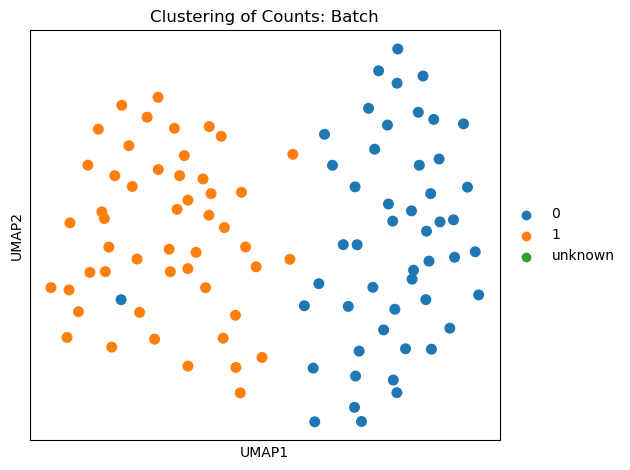

In [ ]:
fac.visualize_embedding("counts", ir_name="endogenous")

PREFFECT has the option to perform Leiden clustering of the samples using the generated UMAP. 

Leiden clustering finds well-connected clusters from the UMAP embedding of your desired data point (inferred counts, true counts, or the latent space).

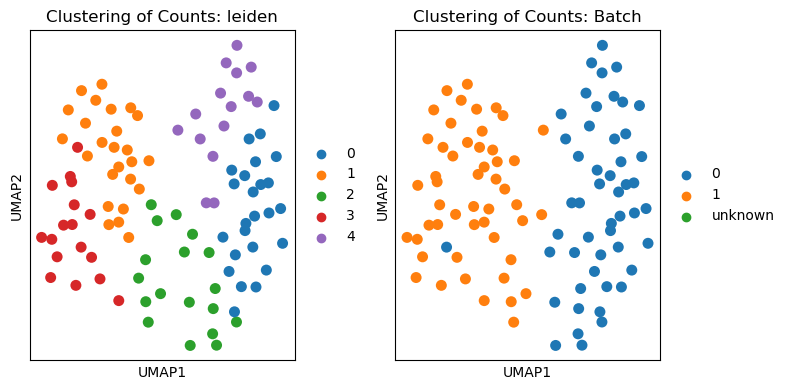

   batch leiden
0      1      3
1      0      0
2      0      4
3      1      1
4      1      2
..   ...    ...
95     1      3
96     1      1
97     1      1
98     1      2
99     1      1

[100 rows x 2 columns]


In [8]:
fac.generate_embedding("counts", ir_name="endogenous")
fac.visualize_embedding("counts", ir_name="endogenous", perform_leiden=True)

print(fac.cluster.leiden_assignment)

Batch Adjustment:

PREFFECT allows one to adjust the model to treat all samples as if it were derived from a particular batch. 

In this dataset, two batches exist (batch 0 and 1). 

Here, we will set samples to all resemble "batch 0".

In [6]:
# set what batch you wish your samples be adjusted to
fac.configs['adjust_vars'] = True
fac.configs['adjust_to_batch_level'] = 0

inf = fac.inference()

We use clustering to show that batch adjustment is having an effect.

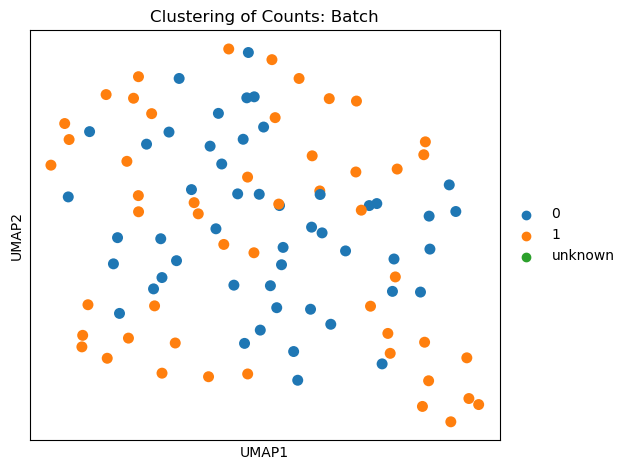

In [12]:
fac.visualize_embedding("counts", ir_name="inference_0", cluster_omega=False)